# Import Libraries

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### From sklearn - Preprocesing 
from sklearn import preprocessing
from sklearn.neighbors import LocalOutlierFactor

# Dimension reduction 
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# K-fold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV

# From sklearn - Model creation

from sklearn.model_selection import train_test_split 
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import multilabel_confusion_matrix
from sklearn import metrics 

# Index

1. Reading files and merging features with labels
2. Preprocesing phase <br>
    2.1 Encoding labels<br>
    2.2 Normalization: min_max_scaler<br>
3. Model Implementation: Decision Tree
        3.1 PCA_80% Training data, 20% test data<br>
        3.2 PCA-DT with fixed value<br>
        3.3 LDA_80% Training data, 20% test data<br>
        3.4 LDA-DT with fixed value<br>
        3.5 Stratified Kfold<br>
        3.6 K-Fold function
        3.7 Grid search Function

-----
# 1. Reading files and merging features with labels

In [33]:
#dataset = pd.read_csv("Genes\data.csv")
dataset = pd.read_csv('/Users/pedrorodriguezdeledesmajimenez/1_Coding/Datasets/RUG_Pattern-recognition_Assignment-2/Task 1/Genres/data.csv')

#labels = pd.read_csv("Genes\labels.csv")
dataset_labels =pd.read_csv('/Users/pedrorodriguezdeledesmajimenez/1_Coding/Datasets/RUG_Pattern-recognition_Assignment-2/Task 1/Genres/labels.csv')

In [34]:
# Merging both datasets and removing first column

dataset = pd.merge(dataset, dataset_labels, on='Unnamed: 0').drop("Unnamed: 0", axis=1)

----
# 2. Preprocesing data

##  2.1 Encoding labels

In [35]:
# Encode the labels and updaate values
le = preprocessing.LabelEncoder()
dataset["Class"] = le.fit_transform(dataset_labels.drop("Unnamed: 0", axis=1).values.ravel())

In [36]:
# Let´s store all the labels
keys = le.classes_

# And now store labels with their encoded value 
values = le.transform(le.classes_)
dictionary = dict(zip(keys, values))

## 2.2 Normalization: min_max_scaler

In [37]:
# Lets store the dataset values without the columns titles
x = dataset.iloc[:, :-1].values 

# Let´s create an instance with the normalice function
min_max_scaler = preprocessing.MinMaxScaler()

# Let´s fit the normilice function
x_scaled = min_max_scaler.fit_transform(x)

# Let´s put in the dataframe the values scaled
dataset.iloc[:, :-1] = pd.DataFrame(x_scaled)

#### Output preprocesing

In [38]:
dataset.shape

(801, 20532)

--------------
# 3. Model Implementation:  KNN

--------

## 3.1 PCA_80% Training data, 20% test data

In [39]:
# PCA with different number of features
k = 9

score_array = []
n_components_array = []

for n_components_PCA in [2,3,4,5,6,7,8,9,10,11,12,13,14,15]:
    
    pca = PCA(n_components=n_components_PCA)

    # Apply PCA in input vector
    pca.fit(dataset.iloc[:,:-1]) 

    # Save results in an np.array
    reduced = pca.transform(dataset.iloc[:,:-1])

    # Save labels in an np.array
    x = dataset['Class'].to_numpy()

    # Create final dataframe with reduced dimensions
    dataset_reduced_PCA = pd.DataFrame(np.column_stack((reduced, x)))
    
    lof = LocalOutlierFactor()
    # fit_predict return a numpy array of 1 if not an outlier and -1 if an outlier
    outliers = lof.fit_predict(dataset_reduced_PCA.iloc[:,:-1])

    # select all rows that are not outliers
    mask = outliers != -1

    #unpack the mask to keep only non-outlier examples
    dataset_reduced_PCA = dataset_reduced_PCA[[*mask]]

    input_data = dataset_reduced_PCA.iloc[:,:-1].values
    label_data = dataset_reduced_PCA.iloc[:,-1].values

    # We split the data  
    X_train, X_test, y_train, y_test = train_test_split(input_data,label_data, test_size=0.2)

    # Build and train the model with the k-vlue
    KNN = KNeighborsClassifier(n_neighbors=k)
    KNN.fit(X_train, y_train)

    # We predict the labels of the test data
    y_pred = KNN.predict(X_test)

    # Accuracy of the model
    metrics.accuracy_score(y_test, y_pred)
    
    n_components_array.append(n_components_PCA)
    score_array.append(metrics.accuracy_score(y_test, y_pred))

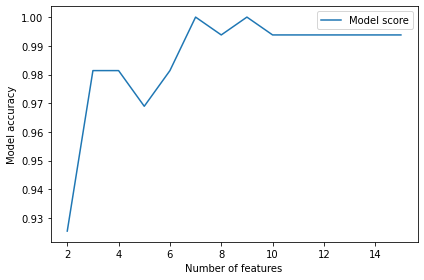

In [40]:
# Plot with regards of components

plt.plot(n_components_array, score_array,label='Model score')
plt.ylabel('Model accuracy')
plt.xlabel('Number of features')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

## 3.2 KNN-PCA with fixed value of PCA 

In [41]:
# Selected value dimension reduction
pca = PCA(0.70)

# Apply PCA in input vector
pca.fit(dataset.iloc[:,:-1]) 

# Save results in an np.array
reduced = pca.transform(dataset.iloc[:,:-1])

# Save labels in an np.array
x = dataset['Class'].to_numpy()

# Create final dataframe with reduced dimensions
dataset_reduced_PCA = pd.DataFrame(np.column_stack((reduced, x)))

lof = LocalOutlierFactor()
# fit_predict return a numpy array of 1 if not an outlier and -1 if an outlier
outliers = lof.fit_predict(dataset_reduced_PCA.iloc[:,:-1])

# select all rows that are not outliers
mask = outliers != -1

#unpack the mask to keep only non-outlier examples
dataset_reduced_PCA = dataset_reduced_PCA[[*mask]]

#For PCA REDUCED data as input
input_data = dataset_reduced_PCA.iloc[:,:-1].values
label_data = dataset_reduced_PCA.iloc[:,-1].values

#For ORIGINAL data as input
#input_data = dataset_reduced_PCA.iloc[:,:-1].values
#label_data = dataset_reduced_PCA.iloc[:,-1].values

# We split the data  
X_train, X_test, y_train, y_test = train_test_split(input_data,label_data, test_size=0.2)

In [44]:
# Build and train the model with the value selected: k= 9
KNN = KNeighborsClassifier(n_neighbors=9)
KNN.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=9)

In [45]:
# We predict the labels of the test data
y_pred = KNN.predict(X_test)

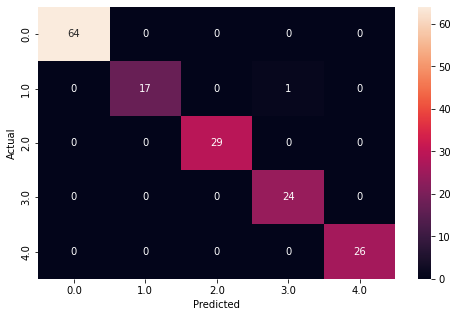

In [46]:
#Confusion matrix to evaluate the model 
plt.figure(figsize=(8,5))
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], 
                               colnames=['Predicted'])

sns.heatmap(confusion_matrix, annot=True)
#plt.savefig("Confusion_Matrix_KNN.png")
plt.show()

In [47]:
# Accuracy of the model
metrics.accuracy_score(y_test, y_pred)

0.9937888198757764

In [48]:
print(f"Accuracy:{metrics.accuracy_score(y_test, y_pred)}")

Accuracy:0.9937888198757764


In [49]:
print(f'More metrics about the model.\n\n' \
      f'{metrics.classification_report(y_test, y_pred, labels=[0.0, 1.0, 2.0, 3.0, 4.0])}')

More metrics about the model.

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        64
         1.0       1.00      0.94      0.97        18
         2.0       1.00      1.00      1.00        29
         3.0       0.96      1.00      0.98        24
         4.0       1.00      1.00      1.00        26

    accuracy                           0.99       161
   macro avg       0.99      0.99      0.99       161
weighted avg       0.99      0.99      0.99       161



----------

## 3.4 LDA_80% Training data, 20% test data

In [50]:
# With different number of features
k = 9

score_array = []
n_components_array_LDA = []

for n_components_LDA in [1,2,3,4]:
    
    lda = LinearDiscriminantAnalysis(n_components=n_components_LDA)

    # Apply PCA in input vector
    lda.fit(dataset.iloc[:,:-1],dataset.iloc[:,-1:].values.ravel()) 

    # Save results in an np.array
    reduced = lda.transform(dataset.iloc[:,:-1])

    # Save labels in an np.array
    x = dataset['Class'].to_numpy()

    # Create final dataframe with reduced dimensions
    dataset_reduced_LDA = pd.DataFrame(np.column_stack((reduced, x)))


    input_data = dataset_reduced_LDA.iloc[:,:-1].values
    label_data = dataset_reduced_LDA.iloc[:,-1].values

    # We split the data  
    X_train, X_test, y_train, y_test = train_test_split(input_data,label_data, test_size=0.2)

    # Build and train the model with the k-vlue
    KNN = KNeighborsClassifier(n_neighbors=k)
    KNN.fit(X_train, y_train)

    # We predict the labels of the test data
    y_pred = KNN.predict(X_test)

    # Accuracy of the model
    metrics.accuracy_score(y_test, y_pred)
    
    n_components_array_LDA.append(n_components_LDA)
    score_array.append(metrics.accuracy_score(y_test, y_pred))

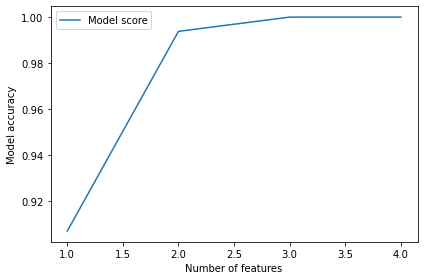

In [51]:
# Plot with regards of components

plt.plot(n_components_array_LDA, score_array,label='Model score')
plt.ylabel('Model accuracy')
plt.xlabel('Number of features')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

## 3.5 KNN-LDA with fixed values

In [52]:
# Selected value dimension reduction 
lda = LinearDiscriminantAnalysis(n_components=4)

# Apply PCA in input vector
lda.fit(dataset.iloc[:,:-1],dataset.iloc[:,-1]) 

# Save results in an np.array
reduced = lda.transform(dataset.iloc[:,:-1])

# Save labels in an np.array
x = dataset['Class'].to_numpy()

# Create final dataframe with reduced dimensions
dataset_reduced_LDA = pd.DataFrame(np.column_stack((reduced, x)))

#For origianl data as input
input_data = dataset.iloc[:,:-1].values
label_data = dataset.iloc[:,-1].values

#For PCA REDUCED data as input
#input_data = dataset_reduced_LDA.iloc[:,:-1].values
#label_data = dataset_reduced_LDA.iloc[:,-1].values

# We split the data  
X_train, X_test, y_train, y_test = train_test_split(input_data,label_data, test_size=0.2)

In [53]:
# Build and train the model with the value selected: k= 9
KNN = KNeighborsClassifier(n_neighbors=9)
KNN.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=9)

In [54]:
# We predict the labels of the test data
y_pred = KNN.predict(X_test)

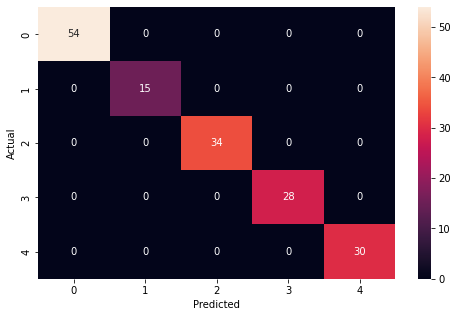

In [55]:
#Confusion matrix to evaluate the model 
plt.figure(figsize=(8,5))
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], 
                               colnames=['Predicted'])

sns.heatmap(confusion_matrix, annot=True)
#plt.savefig("Confusion_Matrix_KNN.png")
plt.show()

In [56]:
# Accuracy of the model
metrics.accuracy_score(y_test, y_pred)

1.0

In [57]:
print(f"Accuracy:{metrics.accuracy_score(y_test, y_pred)}")

Accuracy:1.0


In [58]:
print(f'More metrics about the model.\n\n' \
      f'{metrics.classification_report(y_test, y_pred, labels=[0.0, 1.0, 2.0, 3.0, 4.0])}')

More metrics about the model.

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        54
         1.0       1.00      1.00      1.00        15
         2.0       1.00      1.00      1.00        34
         3.0       1.00      1.00      1.00        28
         4.0       1.00      1.00      1.00        30

    accuracy                           1.00       161
   macro avg       1.00      1.00      1.00       161
weighted avg       1.00      1.00      1.00       161



In [59]:
# Accuracy of the model
metrics.accuracy_score(y_test, y_pred)

print(f"Accuracy:{metrics.accuracy_score(y_test, y_pred)}")

print(f'More metrics about the model.\n\n' \
      f'{metrics.classification_report(y_test, y_pred, labels=[0.0, 1.0, 2.0, 3.0, 4.0])}')

Accuracy:1.0
More metrics about the model.

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        54
         1.0       1.00      1.00      1.00        15
         2.0       1.00      1.00      1.00        34
         3.0       1.00      1.00      1.00        28
         4.0       1.00      1.00      1.00        30

    accuracy                           1.00       161
   macro avg       1.00      1.00      1.00       161
weighted avg       1.00      1.00      1.00       161



## 3.6 Stratified Kfold

In [60]:
input_data = dataset_reduced_LDA.iloc[:,:-1].values
label_data = dataset_reduced_LDA.iloc[:,-1].values

In [61]:
k=9

error_average = []
score_average = []

def get_score(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    return model.score(X_test, y_test)

for k in [3,5,7]:
    folds = StratifiedKFold(n_splits=k, shuffle = True, random_state = 100)
    
    scores = []
    error = []
  
    knn = KNeighborsClassifier(n_neighbors=k)

    for train_index, test_index in folds.split(input_data,label_data):
        X_train, X_test, y_train, y_test = input_data[train_index], input_data[test_index], label_data[train_index], label_data[test_index]

        scores.append(get_score(knn, X_train, X_test, y_train, y_test))

        preds = knn.predict(X_test)
        squared_error = np.power(y_test - preds,2)
        error.append(np.mean(squared_error))
            
    error_average.append(np.mean(error))
    score_average.append(round(np.mean(scores),4))

In [62]:
# Scores with k = [3,5,7]
score_average

[1.0, 1.0, 1.0]